In [109]:
import pandas as pd

# Cargar el dataset
df = pd.read_csv("intermedio_sin_outliers.csv")
dfbasico = pd.read_csv("dataset_crudo.csv")

print("Dataset cargado con éxito.")

Dataset cargado con éxito.


In [110]:
#extraer columna modelo de dfbasico
dfbasico_modelo = dfbasico['Modelo']
#contar ocurrencias de cada modelo
modelo_counts = dfbasico_modelo.value_counts()
modelo_map = {
    'SW4': 'Hilux SW4',
    'q5 sportback': 'Q5',
    'Q3 Sportback': 'Q3',
    'Tiguan Allspace': 'Tiguan',
    'DS7': 'DS7 Crossback',
    'Tiggo 2': 'Tiggo',
    'Tiggo 3': 'Tiggo',
    'Tiggo 4': 'Tiggo',
    'Tiggo 5': 'Tiggo',
    'ML': 'Clase GLE',
    'Clase ML': 'Clase GLE',
    'X-Terra': 'X-Trail',
    'Samurai': 'Jimny',
    'Grand Blazer': 'Trailblazer'
}

# Aplicar reemplazo
dfbasico['Modelo'] = dfbasico['Modelo'].replace(modelo_map)
# Mostrar hasta 200 filas completas (ajustá según necesites)
pd.set_option('display.max_rows', 200)

# Ahora imprimí normalmente
print("Conteo de modelos:")
print(modelo_counts)


Conteo de modelos:
Modelo
Ecosport             1569
Tracker              1511
2008                 1144
Duster               1048
Compass               916
Kicks                 913
Taos                  687
Renegade              643
T-Cross               540
Corolla Cross         482
C4 Cactus             453
Nivus                 436
Tucson                417
Pulse                 341
HR-V                  339
Hilux SW4             322
Territory             280
X1                    264
CR-V                  246
Captur                229
C3 Aircross           228
SW4                   224
Tiguan                211
Q5                    196
Grand Cherokee        193
Journey               185
Kuga                  177
RAV4                  173
X6                    150
Tiguan Allspace       147
Tiggo                 145
Trailblazer           139
Commander             117
Bronco Sport          117
Q3                    114
Sportage              110
Wrangler              109
Duster Oroch

In [111]:
df = df.loc[:, ~df.columns.str.startswith('Modelo')]

df['Modelo'] = dfbasico['Modelo']
#muestras de modelo en el dataset df
muestras_modelo = df['Modelo'].value_counts()

# hacer encoding a columna modelo 
# Guardás los valores únicos durante el factorize
df['Modelo'], modelo_labels = pd.factorize(df['Modelo'])

# Consultar el mapeo
print("Modelo codificado  →  Nombre original")
for i, name in enumerate(modelo_labels):
    print(f"{i} → {name}")

Modelo codificado  →  Nombre original
0 → Ecosport
1 → Tiguan
2 → Compass
3 → X55
4 → Sorento
5 → Tucson
6 → Cayenne
7 → Renegade
8 → 2008
9 → Pulse
10 → Tracker
11 → C4 Cactus
12 → Wrangler
13 → X1
14 → 3008
15 → Q5
16 → Taos
17 → CR-V
18 → Kicks
19 → Q3
20 → Clase GLE
21 → HR-V
22 → Duster
23 → Vitara
24 → T-Cross
25 → RAV4
26 → Kuga
27 → Creta
28 → Corolla Cross
29 → Hilux SW4
30 → Blazer
31 → DS7 Crossback
32 → Trailblazer
33 → Grand Cherokee
34 → Nivus
35 → Santa Fe
36 → X3
37 → Tiggo
38 → X-Trail
39 → X6
40 → Q7
41 → Terios
42 → C3 Aircross
43 → Panamera
44 → X35
45 → Musso
46 → Journey
47 → Duster Oroch
48 → X4
49 → Bronco Sport
50 → Commander
51 → S2
52 → Touareg
53 → Captur
54 → Equinox
55 → 500X
56 → Territory
57 → X5
58 → Q8
59 → Land Cruiser
60 → Macan
61 → Soul
62 → C3
63 → Q2
64 → Range Rover
65 → Galloper
66 → Koleos
67 → Stelvio
68 → Clase GLA
69 → Grand Vitara
70 → Cherokee
71 → Discovery
72 → Jolion
73 → XC60
74 → Evoque
75 → Terrano II
76 → Myway
77 → Clase GLC
78 → 

In [112]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# 1. ANTIGÜEDAD
# ==============================

anio_actual = 2025
df['antiguedad'] = anio_actual - df['Año']
df.drop(columns=['Año'], inplace=True)

# ==============================
# 2. ESTANDARIZACIÓN
# ==============================

scaler = StandardScaler()
df[['Precio_usd_z', 'Kilómetros_z', 'antiguedad_z']] = scaler.fit_transform(
    df[['Precio_usd', 'Kilómetros', 'antiguedad']]
)

# ==============================
# 3. K-MEANS CLUSTERING
# ==============================

X_cluster = df[['antiguedad', 'Kilómetros']]
kmeans = KMeans(n_clusters=7, random_state=42).fit(X_cluster)
df['cluster_inical'] = kmeans.labels_


# 1. Fusionar clusters
cluster_map = {
    0: 0,
    1: 1,
    2: 1,  
    3: 1, 
    4: 2,
    5: 3,
    6: 3   
}
df['cluster'] = df['cluster_inical'].map(cluster_map)

# 2. Eliminar cluster original
df.drop(columns=['cluster_inical'], inplace=True)

# 4.2 Normalización de antigüedad y log de km
df['antiguedad_norm'] = df['antiguedad'] / df['antiguedad'].max()
df['km_log'] = np.log1p(df['Kilómetros'])

# 4.3 Score de estado del auto (ignorando precio)
df['score_estado_auto'] = (
    0.5 * (1 - df['antiguedad_norm']) + 
    0.5 * (1 - df['km_log'] / df['km_log'].max())
)

# 4.4 Clasificación por edad
def clasificar_antiguedad(años):
    if años > 10:
        return 'viejo'
    elif años > 5:
        return 'usable'
    else:
        return 'relativamente_nuevo'

df['estado_edad'] = df['antiguedad'].apply(clasificar_antiguedad)


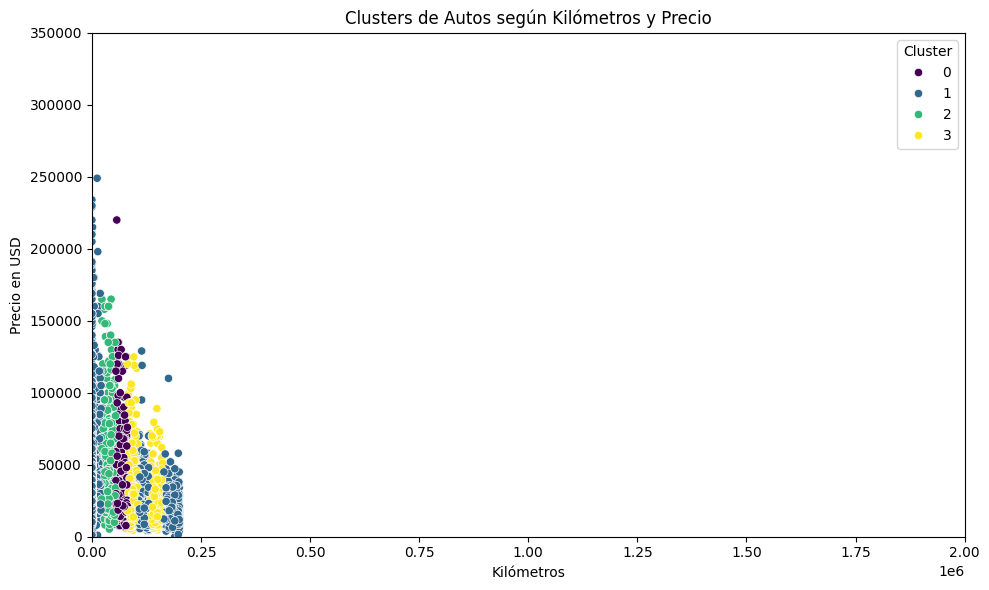

cluster
0    2451
1    9052
2    1948
3    3887
Name: count, dtype: int64


In [113]:
# graficar clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Kilómetros', y='Precio_usd', hue='cluster', data=df, palette='viridis')
plt.title('Clusters de Autos según Kilómetros y Precio')
plt.xlabel('Kilómetros')
plt.ylabel('Precio en USD')
plt.legend(title='Cluster')
plt.xlim(0, 2000000)
plt.ylim(0, 350000)
plt.tight_layout()
plt.show()
print(df['cluster'].value_counts().sort_index())

In [114]:
# One-hot encoding y conversión a enteros
estado_dummies = pd.get_dummies(df['estado_edad'], prefix='estado').astype(int)

# Reemplazar en el DataFrame
df = pd.concat([df.drop(columns=['estado_edad']), estado_dummies], axis=1)
# imprimir las primeras filas del dataset final
pd.set_option('display.max_rows', 200)
#drop columna Precio_usd_z
df.drop(columns=['Precio_usd_z'], inplace=True)


df.drop(columns=['Kilómetros_z', 'antiguedad_z', 'antiguedad_norm', 'km_log'], inplace=True)

# guardar el dataset final
df.to_csv("dataset_final.csv", index=False)
print("Dataset final guardado como 'dataset_final.csv'.")


Dataset final guardado como 'dataset_final.csv'.


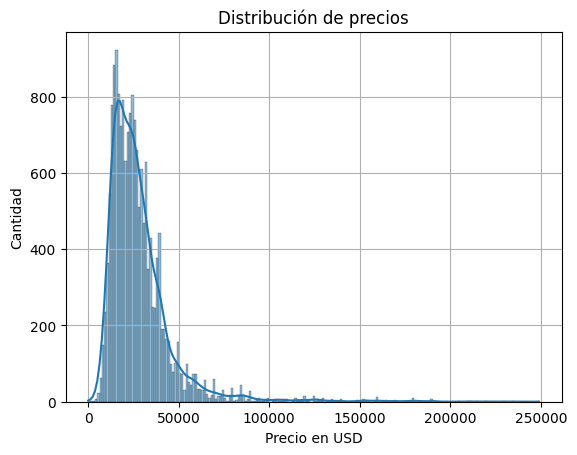

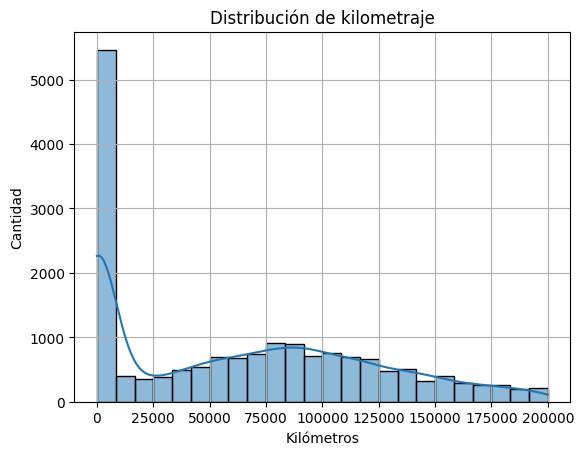

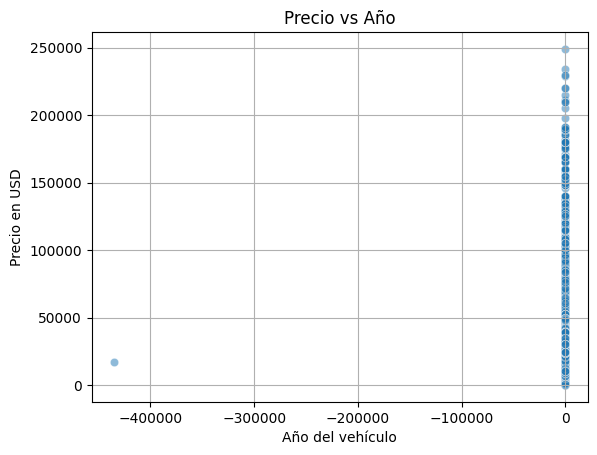

In [115]:
# Histograma de precios
sns.histplot(df['Precio_usd'], kde=True)
plt.title("Distribución de precios")
plt.xlabel("Precio en USD")
plt.ylabel("Cantidad")
plt.grid(True)
plt.show()

# Distribución de kilómetros
sns.histplot(df['Kilómetros'], kde=True)
plt.title("Distribución de kilometraje")
plt.xlabel("Kilómetros")
plt.ylabel("Cantidad")
plt.grid(True)
plt.show()

# Relación año vs. precio
sns.scatterplot(x='antiguedad', y='Precio_usd', data=df, alpha=0.5)
plt.title("Precio vs Año")
plt.xlabel("Año del vehículo")
plt.ylabel("Precio en USD")
plt.grid(True)
plt.show()
